In [99]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import warnings

warnings.simplefilter("ignore", DeprecationWarning)

In [2]:
case = pd.read_csv("data/data/covid_19.csv")
hos1 = pd.read_csv("data/data/hospital1.csv").iloc[:, 1:]


In [3]:
case["submission_date"] = case["submission_date"].astype("datetime64")
case = case.loc[:, ["submission_date", "state", "tot_cases", "new_case"]]
case["lag_date"] = case["submission_date"].shift(1)

In [4]:
join = pd.merge(case, case, how="left", left_on = ["submission_date", "state"], right_on = ["lag_date", "state"])
join["inc_rate"] = join["new_case_y"] / join["tot_cases_x"] 
join = join.fillna(0)

In [78]:
def helper1(state):
    tmp = join[join["state"] == state].reset_index(drop=True)
    inf_ind = np.where(tmp.inc_rate==math.inf)[0]
    return tmp.loc[inf_ind[0]+1:, ["submission_date_x", "state", "inc_rate"]] if inf_ind else tmp.loc[:, ["submission_date_x", "state", "inc_rate"]]
    
case_ = pd.concat([helper1(x) for x in np.unique(join["state"])],axis=0).reset_index(drop=True)
case_.columns = ["date", "state", "inc_rate"]

In [158]:
def helper2(state, shift=1):
    tmp = case_[case_["state"] == state]
    for i in range(1, shift+1):
        varname = "lag_" + str(i)
        tmp[varname] = tmp["inc_rate"].shift(i)
    return tmp

data = pd.concat([helper2(x, shift=7) for x in np.unique(join["state"])],axis=0).dropna().reset_index(drop=True)

C:\Users\cnyin\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [130]:
hos2 = pd.read_csv("data/data/hospital2.csv")
d = {"APR": 4, "MAY": 5, "JUN": 6, "JUL": 7}
hos2["month"] = hos2[["month"]].applymap(lambda x: d[x])
hos2["date"] = pd.to_datetime(hos2[['year', 'day', 'month']]) # concat date
hos2 = hos2.filter(["date", "state"] + hos2.columns[hos2.columns.str.contains("Est")].to_list(), axis=1)

var_list = ["InpatBeds_Occ_AnyPat_Est", "InpatBeds_Occ_AnyPat_Est_Avail", "InpatBeds_Occ_COVID_Est", "ICUBeds_Occ_AnyPat_Est", "ICUBeds_Occ_AnyPat_Est_Avail"]

for var in var_list: ## log-scale the discrete variables 
    hos2["Log_"+var] = np.log(hos2[var]+1)
    hos2 = hos2.drop(var, axis=1)

In [159]:
case_hos = pd.merge(data, hos2, how='inner', on=['state', 'date'])

In [160]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X = case_hos.iloc[:, 3:]
y = case_hos.iloc[:, 2]

idx_train = case_hos["date"] <= "2020-06-01"
idx_test = case_hos["date"] > "2020-06-01"

columns = X.columns

X_train = X.loc[idx_train, :]
X_test = X.loc[idx_test, :]
y_train = y[idx_train]
y_test = y[idx_test]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3062, 15) (1872, 15) (3062,) (1872,)


In [161]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

In [165]:
def rmse(y, y_pred):
    return np.sqrt(((y-y_pred)**2).mean())

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
print(rmse(rf.predict(X_train), y_train))
print(rmse(rf.predict(X_test), y_test))

0.011055878282089537
0.010941301984969625


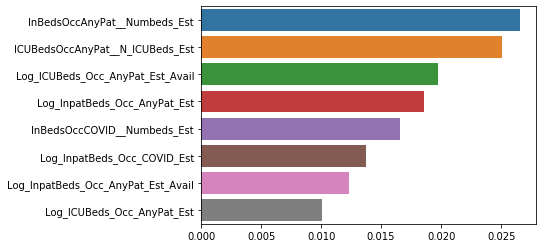

In [166]:
from sklearn.inspection import permutation_importance
importances = permutation_importance(rf, X_train, y_train)

idx = np.argsort(-importances['importances_mean'])[7:]
sns.barplot(importances['importances_mean'][idx], columns[idx]);

In [146]:
case_hos

,date,state,inc_rate,lag_1,InBedsOccAnyPat__Numbeds_Est,InBedsOccCOVID__Numbeds_Est,ICUBedsOccAnyPat__N_ICUBeds_Est,Log_InpatBeds_Occ_AnyPat_Est,Log_InpatBeds_Occ_AnyPat_Est_Avail,Log_InpatBeds_Occ_COVID_Est,Log_ICUBeds_Occ_AnyPat_Est,Log_ICUBeds_Occ_AnyPat_Est_Avail
0,2020-04-01,AK,0.027972,0.075188,57.6,4.3,54.7,6.278521,5.973810,3.713572,4.418841,4.234107
1,2020-04-02,AK,0.068027,0.027972,56.7,5.6,48.0,6.263398,5.993961,3.970292,4.290459,4.369448
2,2020-04-03,AK,0.089172,0.068027,55.2,5.2,42.7,6.236370,6.028279,3.891820,4.174387,4.465908
3,2020-04-04,AK,0.081871,0.089172,49.0,2.6,44.7,6.398595,6.439350,3.496508,4.304065,4.521789
4,2020-04-05,AK,0.032432,0.081871,48.5,3.9,51.8,6.388561,6.448889,3.912023,4.454347,4.382027
...,...,...,...,...,...,...,...,...,...,...,...,...
4929,2020-07-03,WY,0.015171,0.020645,47.0,1.5,90.3,6.075346,6.194405,2.708050,4.060443,1.945910
4930,2020-07-04,WY,0.017435,0.015171,48.7,1.3,85.7,6.111467,6.165418,2.564949,4.007333,2.302585
4931,2020-07-05,WY,0.025092,0.017435,47.0,1.5,65.7,6.084499,6.204558,2.708050,3.737670,3.091042
4932,2020-07-06,WY,0.021493,0.025092,44.3,2.0,67.7,6.013715,6.244167,2.944439,3.761200,3.091042
